In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import os
import shutil
from Bio import SeqIO
from Bio import AlignIO
import distance
import editdistance
import math
import subprocess
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import collections

mpl.rcParams['font.size'] = 24

In [22]:
GENOME_VERSION = 'v032'
PROTEINORTHO_STATUS = 'no_proteinortho' # either 'proteinortho' or 'no_proteinortho'

YN00_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/yn00.ctl'
BASE_OUT_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/%s_%s' % (GENOME_VERSION, PROTEINORTHO_STATUS)
ALLELE_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/defining_alleles/%s_%s/allele_analysis/alleles_proteinortho_graph516/' % (GENOME_VERSION, PROTEINORTHO_STATUS)
UNFILTERED_DF_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/defining_alleles/%s_%s/allele_analysis/DK_0911_%s_p_ctg.DK_0911_%s_h_ctg.0.001.blastp.outfmt6.allele_analysis' % (GENOME_VERSION, PROTEINORTHO_STATUS, GENOME_VERSION, GENOME_VERSION)
GENOME_PATH = '/home/gamran/genome_analysis/Warrior/Richard/output/genome_%s/' % GENOME_VERSION
FIGURE_PATH = os.path.join(BASE_OUT_PATH, 'figures')

GENOME = 'DK_0911_%s' % GENOME_VERSION
P_GENOME = GENOME + '_p_ctg'
H_GENOME = GENOME + '_h_ctg'

PAML_PATH = os.path.join(BASE_OUT_PATH, 'paml')
if not os.path.exists(BASE_OUT_PATH):
    os.mkdir(BASE_OUT_PATH)
if not os.path.exists(FIGURE_PATH):
    os.mkdir(FIGURE_PATH)
if not os.path.exists(PAML_PATH):
    os.mkdir(PAML_PATH)
    shutil.copy2(YN00_PATH, PAML_PATH)

In [4]:
# Create DataFrame with all alleles
overlapDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.h_contig_overlap.alleles' % P_GENOME), header=None, names=['alleleOne', 'alleleTwo'], sep='\t')
noOverlapDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.no_specific_h_contig_overlap.alleles' % P_GENOME), header=None, names=['alleleOne', 'alleleTwo'], sep='\t')
diffContigDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.no_respective_h_contig_overlap.alleles' % P_GENOME), header=None, names=['alleleOne', 'alleleTwo'], sep='\t')
manualAssignDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.manual_assigned.alleles' % H_GENOME), header=None, names=['alleleOne', 'alleleTwo'], sep='\t')

overlapDf['matchType'] = 'overlap'
noOverlapDf['matchType'] = 'no_overlap'
diffContigDf['matchType'] = 'different_pcontig'
manualAssignDf['matchType'] = 'manual_assigned'

alleleDf = overlapDf.append([noOverlapDf, diffContigDf, manualAssignDf])

alleleDf['folder'] = alleleDf.alleleOne + '_' + alleleDf.alleleTwo
alleleDf.set_index('folder', inplace=True)

assert(len(alleleDf) == len(overlapDf) + len(noOverlapDf) + len(diffContigDf) + len(manualAssignDf))

In [5]:
# Combine haplotig & primary contig fasta files for each allele type
# (protein, gene, CDS), and change headings so that they use id 
# (e.g. evm.model.pcontig_057.39) instead of locus tag (e.g. DK0911_16805).

## obsolete in v031. All relevant fasta files are generated in DK_0911_v03_generate_fa_files_from_gff3.ipynb
# os.chdir('/home/gamran/genome_analysis/Warrior/Richard/scripts')
# %run DK_0911_v03_dictionaries.ipynb
# locusToIdDict = getLocusToIdDict()

# def combineCtgFastaFiles(fastaFiles, fOut):
#     '''combines fasta files and rewrites headings from locus tags
#     (DK0911_16805) to id tags (evm.model.pcontig_057.39)'''
#     with open(fOut, 'w') as outFile:
#         for fastaFile in fastaFiles:
#             with open(fastaFile, 'r') as inFile:
#                 for line in inFile:
#                     if '>' in line:
#                         line = '>' + locusToIdDict[line[1:-1]] + '\n'
#                     outFile.write(line)
#     return True

# hProteinFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_h_ctg.protein.fa')
# pProteinFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_p_ctg.protein.fa')
# hGeneFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_h_ctg.gene.fa')
# pGeneFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_p_ctg.gene.fa')
# hCDSFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_h_ctg.CDS.fa')
# pCDSFasta = os.path.join(GENOME_PATH, 'DK_0911_v03_p_ctg.CDS.fa')

PH_PROTEIN_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.protein.fa')
PH_GENE_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.gene.fa')
PH_CDS_FASTA = os.path.join(GENOME_PATH, GENOME + '_ph_ctg.cds.fa')

# combineCtgFastaFiles([hProteinFasta, pProteinFasta], PH_PROTEIN_FASTA)
# combineCtgFastaFiles([hGeneFasta, pGeneFasta], PH_GENE_FASTA)
# combineCtgFastaFiles([hCDSFasta, pCDSFasta], PH_CDS_FASTA)

In [6]:
def getFastaDict(fastaFile):
    d = {}
    for gene in SeqIO.parse(fastaFile, 'fasta'):
        d[gene.id] = gene
    return d

SEQRECORD_PROTEIN_DICT = getFastaDict(PH_PROTEIN_FASTA)
SEQRECORD_GENE_DICT = getFastaDict(PH_GENE_FASTA)
SEQRECORD_CDS_DICT = getFastaDict(PH_CDS_FASTA)

In [7]:
# def getSpecificFasta(geneList, fastaFile):
#     '''Returns the fasta of gene in list as SeqIO object '''
#     # Ben's original code had CDS with '.model.' and 
#     # protein as '.TU.'
#     l = []
#     for gene in SeqIO.parse(fastaFile, 'fasta'):
#         if gene.id in geneList:
#             l.append(gene)
#     return l
# 
# def writeAllelicFasta(alleleOne, alleleTwo, alleleType, outPath):
#     '''writes fasta file containing fasta information for two alleles
#     in the outPath'''
#     assert(alleleType.upper() in ['CDS', 'GENE', 'PROTEIN'])
#     fastaFilePath = globals()['PH_' + alleleType.upper() + '_FASTA'] # e.g. alleleType = 'GENE', then fastaFile = PH_GENE_FASTA
#     specificFastaList = getSpecificFasta([alleleOne, alleleTwo], fastaFilePath)
#     with open(os.path.join(outPath, alleleType.lower() + '.fa'), 'w') as outFile:
#         SeqIO.write(specificFastaList, outFile, 'fasta')
#     return True

def writeAllelicFasta(alleleOne, alleleTwo, alleleType, outPath):
    '''writes fasta file containing fasta information for two alleles
    in the outPath'''
    assert(alleleType.upper() in ['CDS', 'GENE', 'PROTEIN'])
    
    seqRecordDict = globals()['SEQRECORD_' + alleleType.upper() + '_DICT']
    
    alleleSeqRecords = [seqRecordDict[alleleOne], seqRecordDict[alleleTwo]]
    with open(os.path.join(outPath, alleleType.lower() + '.fa'), 'w') as outFile:
        SeqIO.write(alleleSeqRecords, outFile, 'fasta')
    return True

def writeAlignmentScript(alleleOutPath, scriptLoc = os.path.join(PAML_PATH, 'paml_script.sh')):
    with open(scriptLoc, 'a') as outFile:
        print('cd %s' % alleleOutPath, file=outFile)
        print('/home/gamran/anaconda3/muscle3.8.31_i86linux64 -clwstrict -in protein.fa -out protein.aln', file=outFile)
        print('perl /home/gamran/anaconda3/pal2nal.v14/pal2nal.pl -output paml protein.aln cds.fa > cds_codon.aln', file=outFile)
        print('perl /home/gamran/anaconda3/pal2nal.v14/pal2nal.pl protein.aln cds.fa > cds_codon.clustal', file=outFile)
        print('cp %s/yn00.ctl ./' % PAML_PATH, file=outFile)
        print('/home/gamran/anaconda3/paml4.9g/bin/yn00', file=outFile)
    return True

In [8]:
def prepareAlignmentBashScript(scriptLoc = os.path.join(PAML_PATH, 'paml_script.sh')):
    with open(scriptLoc, 'w') as pamlScript:
        print('#!/bin/bash', file=pamlScript)

    for index, [alleleOne, alleleTwo, alleleType] in alleleDf.iterrows():

        alleleOutPath = os.path.join(PAML_PATH, '%s_%s' % (alleleOne, alleleTwo))
        if not os.path.exists(alleleOutPath):
            os.mkdir(os.path.join(PAML_PATH, '%s_%s' % (alleleOne, alleleTwo)))

        writeAllelicFasta(alleleOne, alleleTwo, 'CDS', alleleOutPath)
        writeAllelicFasta(alleleOne, alleleTwo, 'PROTEIN', alleleOutPath)

        writeAlignmentScript(alleleOutPath, os.path.join(PAML_PATH, 'paml_script.sh'))

In [9]:
# alleleDf['folder'] = alleleDf.alleleOne + '_' + alleleDf.alleleTwo
# alleleDf.index = alleleDf['folder']

In [10]:
def assignDistancesToAlleles(df, folder, alignmentFile, alleleType):
    '''Adds Hamming and Levenshtein distance columns to an allele pair
    (indexed by 'folder' name) in df'''
    assert(alleleType.upper() in ['PROTEIN', 'CDS', 'GENE'])
    seq1, seq2 = AlignIO.read(open(alignmentFile, 'r'), format='clustal', seq_count=2)
    seq1 = str(seq1.seq).upper()
    seq2 = str(seq2.seq).upper()
    assert(len(seq1) == len(seq2))
    df.loc[folder, alleleType.lower() + '_hamming'] = distance.hamming(seq1, seq2, normalized=True)
    df.loc[folder, alleleType.lower() + '_levenshtein'] = editdistance.eval(seq1, seq2)/len(seq1)
    return df

def assignDistancesToAllAlleles(alleleDf):
    count = 0
    total = len(alleleDf)
    percentDone = 0
    
    print("Calculating distances and adding them to the allele DataFrame...")
    
    for folder in alleleDf.index:

        proteinAlignmentFile = os.path.join(PAML_PATH, folder, 'protein.aln')
        alleleDf = assignDistancesToAlleles(alleleDf, folder, proteinAlignmentFile, 'PROTEIN')

        cdsAlignmentFile = os.path.join(PAML_PATH, folder, 'cds_codon.clustal')
        alleleDf = assignDistancesToAlleles(alleleDf, folder, cdsAlignmentFile, 'CDS')

        count += 1
        if round(count/total * 100) > percentDone:
            percentDone = round(count/total * 100)
            print("%s%% complete" % percentDone)
    return alleleDf

In [11]:
def parse_dNdS_to_df(line, alleleDf, folder, dNdS_label):
    dN = re.findall(r'dN = [-| ]?(.*) w', line)[0]
    dS = re.findall(r'dS = [-| ]?(.*) dN', line)[0]
    return assign_dNdS(dN, dS, alleleDf, folder, dNdS_label)

def assign_dNdS(dN, dS, alleleDf, folder, dNdS_label):
    if float(dS) > 0:
        alleleDf.loc[folder, dNdS_label] = float(dN)/float(dS)
    else:
        alleleDf.loc[folder, dNdS_label] = np.nan
    return alleleDf

def assign_dNdS_to_all_alleles(alleleDf):
    for folder in alleleDf.index:
        alleleYn = os.path.join(PAML_PATH, folder,'yn.out')
        with open(alleleYn, 'r') as ynOut:
            #now loop over the lines and parse out stuff
            for i, line in enumerate(ynOut):
                if line.startswith('seq. seq. ') and i > 0:
                    next(ynOut) # we want the line that is two after the line starting with 'seq. seq '
                    dataLine = next(ynOut)
                    dN = dataLine.split('+-')[0].rstrip().split(' ')[-1]
                    dS = dataLine.split('+-')[1].rstrip().split(' ')[-1]
                    alleleDf = assign_dNdS(dN, dS, alleleDf, folder, 'yn00_dN/dS')
                elif line.startswith('LWL85:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LWL85_dN/dS')
                elif line.startswith('LWL85m:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LWL85m_dN/dS')
                elif line.startswith('LPB93:') and 'nan' not in line:
                    alleleDf = parse_dNdS_to_df(line, alleleDf, folder, 'LPB93_dN/dS')
                else:
                    continue
    return alleleDf

In [12]:
def main(alleleDf = alleleDf):
    prepareAlignmentBashScript(os.path.join(PAML_PATH, 'paml_script.sh'))
    
    # !bash {os.path.join(PAML_PATH, 'paml_script.sh')}
    
    distDfPath = os.path.join(BASE_OUT_PATH, GENOME+'_distanceDf.df')
    if os.path.exists(distDfPath) and os.path.getsize(distDfPath) > 0:
        print("DataFrame with distance calculations at %s appears to have already been generated. Reading in this dataframe instead of re-generating it." % distDfPath)
        alleleDf = pd.read_csv(distDfPath, sep='\t', index_col=0)
    else:
        alleleDf = assignDistancesToAllAlleles(alleleDf)
        alleleDf.to_csv(distDfPath, sep='\t')
        pd.util.testing.assert_frame_equal(alleleDf, pd.read_csv(distDfPath, sep='\t', index_col=0))
    
    alleleDf = assign_dNdS_to_all_alleles(alleleDf)
    alleleDf.to_csv(distDfPath, sep='\t')
    
    return alleleDf

In [13]:
if __name__ == "__main__":
    alleleDf = main()

DataFrame with distance calculations at /home/gamran/genome_analysis/Warrior/Richard/output/post_analysis/v032_no_proteinortho/DK_0911_v032_distanceDf.df appears to have already been generated. Reading in this dataframe instead of re-generating it.


In [15]:
def plotAlleles(alleleDf):
    dist = alleleDf.groupby(['matchType']).mean()
    dist.head()
    noAlleleDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.no_alleles' % P_GENOME), header=None, names=['alleleOne'], sep='\t')


,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS
matchType,,,,,,,,
different_pcontig,0.611787,0.608406,0.565956,0.540131,0.415864,0.791001,0.477329,0.877313
manual_assigned,0.598791,0.598287,0.591157,0.584317,0.583990,1.077810,0.597723,1.191550
no_overlap,0.709279,0.705140,0.655466,0.623647,0.312446,0.338321,0.400563,0.404466
overlap,0.147971,0.147791,0.144289,0.140639,0.565847,0.735199,0.574495,0.761850


In [16]:
noAlleleDf = pd.read_csv(os.path.join(ALLELE_PATH, '%s.no_alleles' % P_GENOME), header=None, names=['alleleOne'], sep='\t')

2059

In [17]:
# The filtering process may result in one primary protein having more than one allele (e.g. same e-value & bitscore).
# BUT all primary proteins with more than one allele are all of the same matchType (run below code to prove).
# int(alleleDf.groupby('alleleOne')['matchType'].agg(lambda s:np.unique(s).size==1).value_counts())

# alleleDf.groupby('matchType').agg(lambda x: x.nunique())

# OrderedDict to preserve order, so that plots are coloured with same key as the distance 
# bar graphs. This is a bit of a hack-fix; must enter these by hand again in the same order 
# as 'matchType' occurs in the dist DataFrame.
pProteinTypeCountDict = collections.OrderedDict()
pProteinTypeCountDict['different_pcontig'] = len(alleleDf[alleleDf['matchType'] == 'different_pcontig']['alleleOne'].unique())
pProteinTypeCountDict['no_allele'] = len(noAlleleDf['alleleOne'].unique())
pProteinTypeCountDict['no_overlap'] = len(alleleDf[alleleDf['matchType'] == 'no_overlap']['alleleOne'].unique())
pProteinTypeCountDict['overlap'] = len(alleleDf[alleleDf['matchType'] == 'overlap']['alleleOne'].unique())

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
    return my_autopct

In [18]:
pProteinTypeCountDict

OrderedDict([('different_pcontig', 3321),
             ('no_allele', 2059),
             ('no_overlap', 2266),
             ('overlap', 10535)])

In [19]:
print(plt.style.available)

['seaborn-bright', 'seaborn-dark', 'seaborn-paper', 'seaborn-notebook', 'fivethirtyeight', 'seaborn-darkgrid', 'bmh', 'classic', 'seaborn-deep', 'seaborn-talk', 'seaborn-white', 'seaborn-colorblind', 'seaborn-whitegrid', 'seaborn-muted', 'seaborn-pastel', 'seaborn-poster', 'seaborn-ticks', 'grayscale', 'seaborn-dark-palette', 'dark_background', 'ggplot']


In [20]:
def autolabel(rects, labels, ax, fontsize):
    """
    Attach a text label above each bar displaying its height
    """
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height, str(labels[i]), ha='center', va='bottom', fontsize=fontsize)

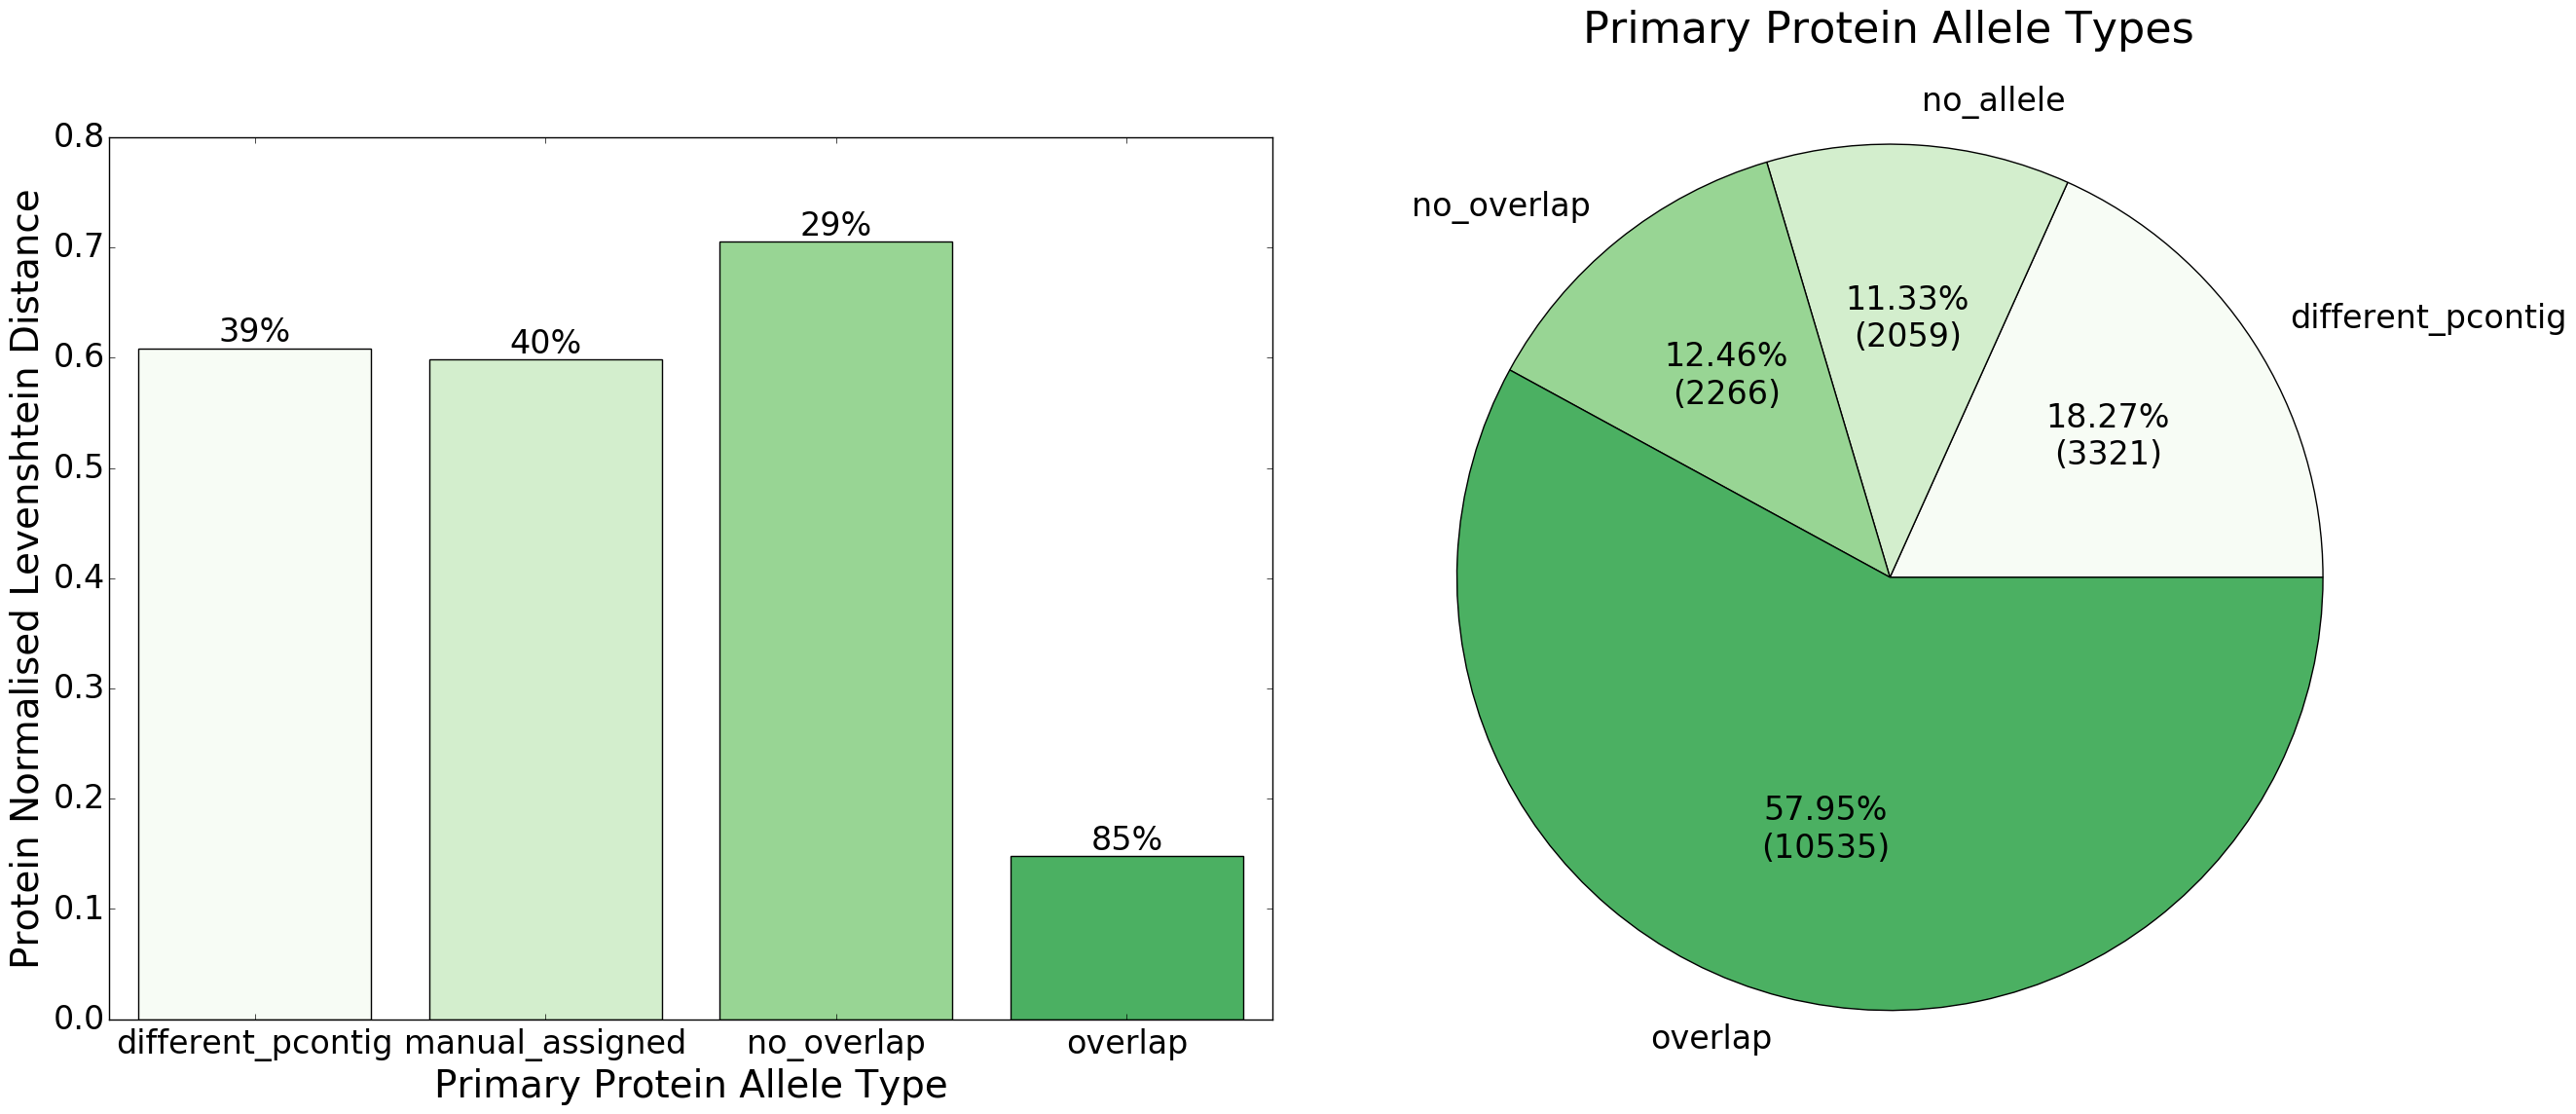

In [21]:
TITLE_SIZE = 32
AXIS_LABEL_SIZE = 28
AXIS_TICK_SIZE = 24
INLINE_LABEL_SIZE = 24

# colormaps at https://matplotlib.org/examples/color/colormaps_reference.html
cmap = plt.cm.Greens
colors = cmap(np.linspace(0.0, 0.6, len(pProteinTypeCountDict)))

fig, ax = plt.subplots(1, 2, figsize=(26, 12))

width = 0.35
ind = np.arange(len(dist.protein_levenshtein))
rects = ax[0].bar(ind, dist.protein_levenshtein, color=colors, align='center')#, linewidth=0)

barLabels = []
for levDist in dist.protein_levenshtein:
    barLabels.append(str(int((1-levDist)*100)) + '%')
autolabel(rects, barLabels, ax[0], INLINE_LABEL_SIZE)

ax[0].set_xticks(ind)
ax[0].set_xticklabels(dist.index, {'fontsize':AXIS_TICK_SIZE, 'horizontalalignment':'center'})

ax[0].set_xlabel('Primary Protein Allele Type', fontsize=AXIS_LABEL_SIZE)
ax[0].set_ylabel('Protein Normalised Levenshtein Distance', fontsize=AXIS_LABEL_SIZE)

ax[0].tick_params(axis='both', which='major', labelsize=AXIS_TICK_SIZE, pad=3)

for tick in ax[0].get_xaxis().get_major_ticks():
    tick.set_pad(2*tick.get_pad())
    tick.label1 = tick._get_text1()


patches, texts, autotexts = ax[1].pie(list(pProteinTypeCountDict.values()), labels=pProteinTypeCountDict.keys(), autopct=make_autopct(list(pProteinTypeCountDict.values())), colors=colors)
ax[1].axis('equal')
ax[1].set_title('Primary Protein Allele Types', loc='center', fontsize=TITLE_SIZE, position=(0.5, 1.1))
fig.tight_layout()

fig.savefig(os.path.join(FIGURE_PATH, 'fig'), bbox_inches='tight')

# autotexts[0].set_fontsize(20)

# ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
#         shadow=True, startangle=90)
# ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
 

# alleleDf['matchType'].value_counts()

#len(alleleDf)
#len(alleleDf['alleleOne'].unique())

In [24]:
unfiltered_df = pd.read_csv(UNFILTERED_DF_PATH, sep='\t')

In [25]:
unfiltered_df.head()

,Query,Target,PctID,AlnLgth,NumMis,NumGap,StartQuery,StopQuery,StartTarget,StopTarget,e-value,BitScore,QLgth,QCov,q_contig,t_contig,q_contig == t_contig,p_protein,h_contig_overlap,t_contig == h_contig_overlap
0,evm.model.pcontig_000.1,evm.model.hcontig_000_024.1,100.00,317.0,0.0,0.0,1.0,317.0,1.0,317.0,0.0,654.0,951,33.333333,pcontig_000,hcontig_000_024,True,evm.model.pcontig_000.1,['hcontig_000_024'],True
1,evm.model.pcontig_000.1,evm.model.hcontig_003_006.23,94.60,315.0,17.0,0.0,1.0,315.0,1251.0,1565.0,0.0,619.0,951,33.123028,pcontig_000,hcontig_003_006,False,evm.model.pcontig_000.1,['hcontig_000_024'],False
2,evm.model.pcontig_000.1,evm.model.hcontig_013_029.4,94.60,315.0,17.0,0.0,1.0,315.0,1251.0,1565.0,0.0,619.0,951,33.123028,pcontig_000,hcontig_013_029,False,evm.model.pcontig_000.1,['hcontig_000_024'],False
3,evm.model.pcontig_000.1,evm.model.hcontig_085_001.8,91.46,316.0,27.0,0.0,1.0,316.0,1252.0,1567.0,0.0,608.0,951,33.228181,pcontig_000,hcontig_085_001,False,evm.model.pcontig_000.1,['hcontig_000_024'],False
4,evm.model.pcontig_000.1,evm.model.hcontig_033_009.21,82.86,315.0,54.0,0.0,1.0,315.0,1245.0,1559.0,0.0,553.0,951,33.123028,pcontig_000,hcontig_033_009,False,evm.model.pcontig_000.1,['hcontig_000_024'],False


In [27]:
alleleDf.head()

,alleleOne,alleleTwo,matchType,protein_hamming,protein_levenshtein,cds_hamming,cds_levenshtein,yn00_dN/dS,LWL85_dN/dS,LWL85m_dN/dS,LPB93_dN/dS
folder,,,,,,,,,,,
evm.model.pcontig_000.1_evm.model.hcontig_000_024.1,evm.model.pcontig_000.1,evm.model.hcontig_000_024.1,overlap,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN
evm.model.pcontig_000.100_evm.model.hcontig_000_058.5,evm.model.pcontig_000.100,evm.model.hcontig_000_058.5,overlap,0.000000,0.00000,0.000000,0.000000,NaN,NaN,NaN,NaN
evm.model.pcontig_000.1000_evm.model.hcontig_000_078.13,evm.model.pcontig_000.1000,evm.model.hcontig_000_078.13,overlap,0.000000,0.00000,0.003333,0.003333,-0.000000,0.0,0.0,0.0
evm.model.pcontig_000.1001_evm.model.hcontig_000_078.18,evm.model.pcontig_000.1001,evm.model.hcontig_000_078.18,overlap,0.913043,0.90389,0.848970,0.811594,0.556251,NaN,NaN,NaN
evm.model.pcontig_000.1002_evm.model.hcontig_000_078.16,evm.model.pcontig_000.1002,evm.model.hcontig_000_078.16,overlap,0.918367,0.91610,0.876795,0.848828,0.258478,NaN,NaN,NaN
